
# Unet model (with inceptionresnetv2 architecture as the backbone ) to segment the stomach and intestines on MRI scans taken from patients with Intestine Cancer.

#### Kaggle Competition [Link](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/overview)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
import gc
from tqdm import tqdm
from datetime import datetime
from typing import Optional
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt


from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras.models import load_model, save_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.layers import Input

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from config import * 
import os

from utils import *
from train import *
from datagen import *

2022-05-15 03:07:30.286979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/paul/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-05-15 03:07:30.287001: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_df_original = pd.read_csv(TRAIN_ROOT_DIR + 'train.csv')

print(train_df_original.shape)
train_df_original.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


<AxesSubplot:ylabel='class'>

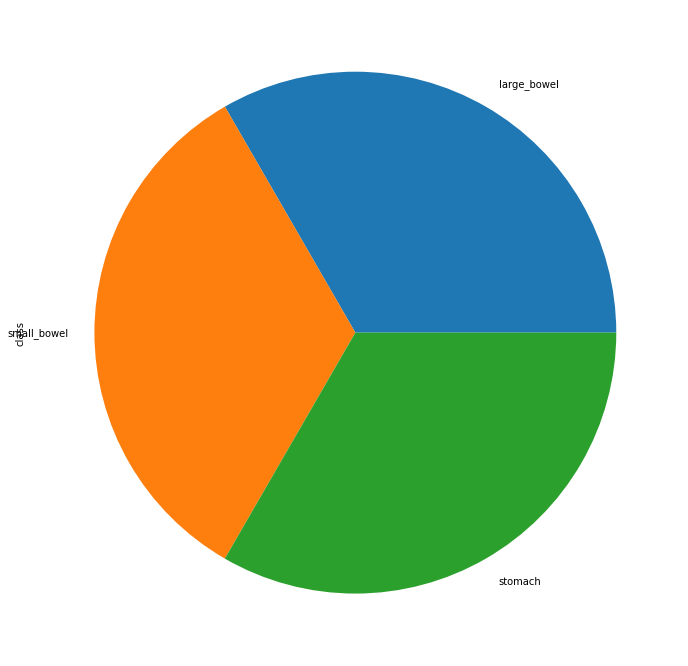

In [3]:
plt.figure(figsize=(28, 12))
train_df_original['class'].value_counts(normalize=True).plot.pie()

In [4]:
test_df = pd.read_csv(TRAIN_ROOT_DIR + 'sample_submission.csv')
test_df.head()

,id,class,predicted


In [5]:

if len(test_df) == 0:
    DEBUG=True
    # test_df=train_df_original.iloc[:300, :]
    test_df=pd.read_csv(TRAIN_ROOT_DIR + 'train.csv').iloc[:300, :]
    test_df['segmentation'] = ''
    test_df = test_df.rename(columns={'segmentation' : 'prediction'})
else:
    DEBUG=False
    
submission = test_df.copy()
test_df.head()

,id,class,prediction
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


In [6]:
# glob("../../input/uw-madison-gi-tract-image-segmentation/train/*/*/*/*")

---

## Function to create a detailed df from train_df

- Create columns with 'case', 'day', 'slice'

In [7]:
train_df_original.head()
train_df_original.shape

(115488, 3)

In [8]:
train_df = df_preparation(train_df_original, subset="train")

train_df.head(10)

all_images length  38496


,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,../../input/uw-madison-gi-tract-image-segmenta...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,../../input/uw-madison-gi-tract-image-segmenta...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,../../input/uw-madison-gi-tract-image-segmenta...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,../../input/uw-madison-gi-tract-image-segmenta...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,../../input/uw-madison-gi-tract-image-segmenta...,266,266
5,case123_day20_slice_0002,stomach,NaN,123,20,0002,../../input/uw-madison-gi-tract-image-segmenta...,266,266
6,case123_day20_slice_0003,large_bowel,NaN,123,20,0003,../../input/uw-madison-gi-tract-image-segmenta...,266,266
7,case123_day20_slice_0003,small_bowel,NaN,123,20,0003,../../input/uw-madison-gi-tract-image-segmenta...,266,266
8,case123_day20_slice_0003,stomach,NaN,123,20,0003,../../input/uw-madison-gi-tract-image-segmenta...,266,266
9,case123_day20_slice_0004,large_bowel,NaN,123,20,0004,../../input/uw-madison-gi-tract-image-segmenta...,266,266


In [9]:
# Checking a single full path name
print(train_df['path'][0])
print(train_df['path'][1])
print(train_df['path'][2])
print(train_df['path'][3])

../../input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png
../../input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png
../../input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png
../../input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png


In [10]:
test_df.head()
test_df.shape

(300, 3)

In [11]:
test_df=df_preparation(test_df, subset="test", DEBUG=True)
test_df.head()

all_images length  38496


,id,class,prediction,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,../../input/uw-madison-gi-tract-image-segmenta...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,../../input/uw-madison-gi-tract-image-segmenta...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,../../input/uw-madison-gi-tract-image-segmenta...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,../../input/uw-madison-gi-tract-image-segmenta...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,../../input/uw-madison-gi-tract-image-segmenta...,266,266


In [12]:
test_df['path'][0]

'../../input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'

## Rearrange train_df

**string[::2]** => reads “default start index, default stop index, step size is two 
  — i.e. take every second element”. So it means, 'nothing for the first argument, nothing for the second, and jump by 2.

In [13]:
train_df_rearranged=df_rearrange_for_3_segmentation_classes(train_df, subset="train")
train_df_rearranged.head(100)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0005,266,266,0
...,...,...,...,...,...,...,...,...,...,...,...
95,case123_day20_slice_0096,14796 1 15059 8 15073 2 15324 20 15590 22 1585...,20890 4 21155 8 21421 10 21687 11 21745 6 2195...,20596 7 20861 9 21125 12 21391 12 21656 13 219...,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0096,266,266,3
96,case123_day20_slice_0097,14792 6 15057 9 15071 7 15322 24 15588 25 1585...,20890 4 21155 7 21209 9 21421 9 21469 18 21687...,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0097,266,266,2
97,case123_day20_slice_0098,14525 7 14789 11 14807 4 15055 13 15070 9 1532...,20679 8 20891 1 20944 10 21155 6 21201 20 2142...,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0098,266,266,2
98,case123_day20_slice_0099,14524 9 14789 14 14805 5 15054 24 15264 3 1532...,20149 6 20413 9 20677 12 20941 15 21155 5 2120...,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0099,266,266,2


In [14]:
# Remove misslabeled training data
train_df_rearranged = train_df_rearranged[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)

train_df_rearranged = train_df_rearranged[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

train_df_rearranged = train_df_rearranged[(train_df['case']!=138)|(train_df['day']!=00)].reset_index(drop=True)

In [15]:
gc.collect()

16

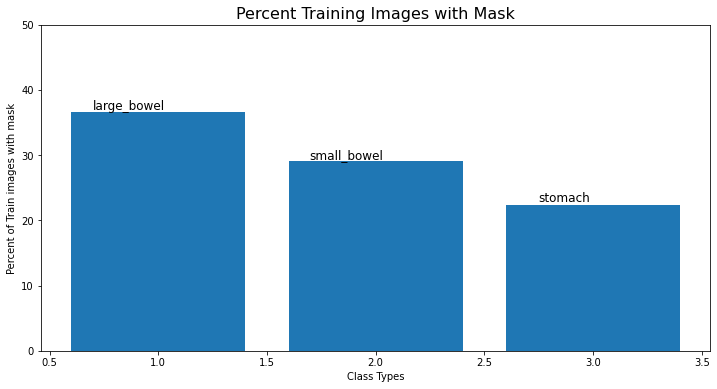

In [16]:
plot_bar(train_df_rearranged)

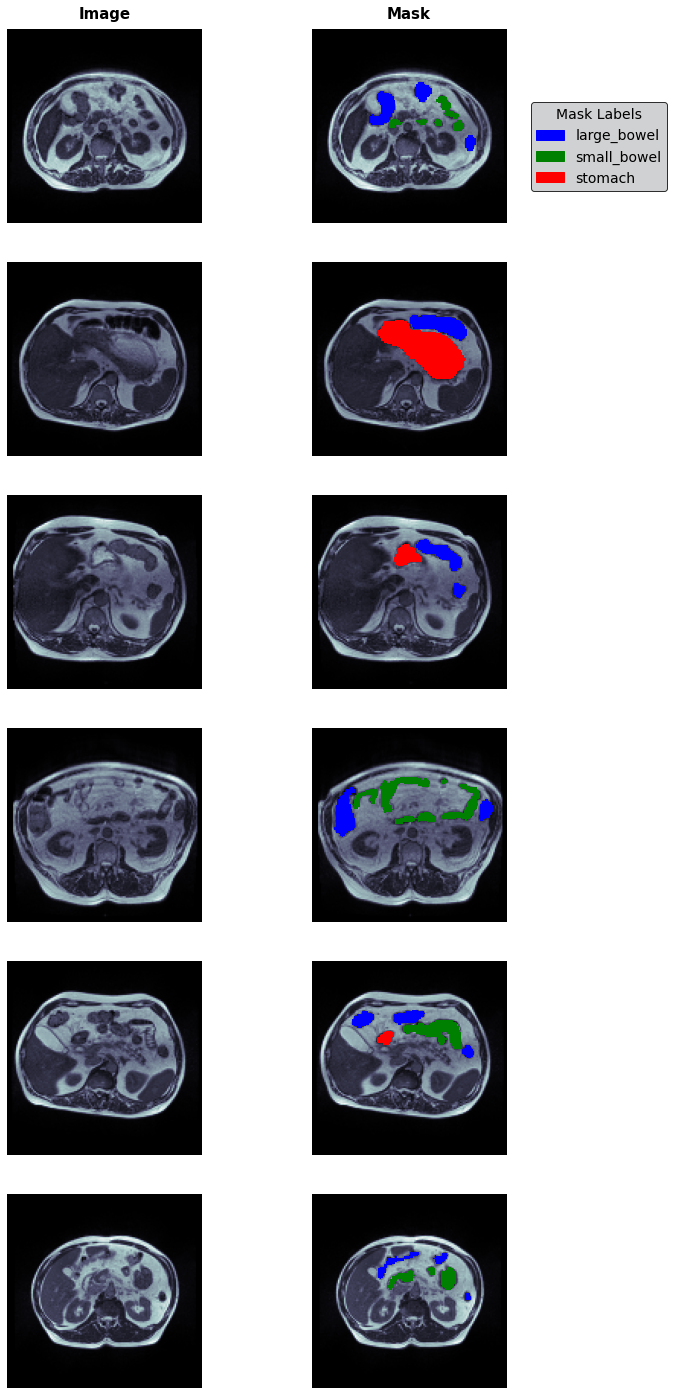

In [17]:
colors = ['blue','green','red']

labels = ["large_bowel", "small_bowel", "stomach"]

plot_mask_with_color_patches(train_df_rearranged, colors, labels)

## StratifiedGroupKFold Cross-Validation

In [18]:
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (_, val_idx) in enumerate(
    skf.split(
        X=train_df_rearranged,
        y=train_df_rearranged["count"],
        groups=train_df_rearranged["case"],
    ),
    1,
):
    train_df_rearranged.loc[val_idx, "fold"] = fold

train_df_rearranged["fold"] = train_df_rearranged["fold"].astype(np.uint8)

train_ids = train_df_rearranged[train_df_rearranged["fold"] != fold_selected].index
valid_ids = train_df_rearranged[train_df_rearranged["fold"] == fold_selected].index

X_train = train_df_rearranged[train_df_rearranged.index.isin(train_ids)]
X_valid = train_df_rearranged[train_df_rearranged.index.isin(valid_ids)]

train_df_rearranged.groupby("fold").size()

fold
1    7920
2    6624
3    7952
4    8624
5    7376
dtype: int64

In [19]:
train_df_rearranged.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count,fold
0,case123_day20_slice_0001,,,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0001,266,266,0,2
1,case123_day20_slice_0002,,,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0002,266,266,0,2
2,case123_day20_slice_0003,,,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0003,266,266,0,2
3,case123_day20_slice_0004,,,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0004,266,266,0,2
4,case123_day20_slice_0005,,,,../../input/uw-madison-gi-tract-image-segmenta...,123,20,0005,266,266,0,2


In [21]:
train_df_rearranged.groupby(['fold','count'])['id'].count()

fold  count
1     0        4486
      1         485
      2        2230
      3         719
2     0        3847
      1         347
      2        1876
      3         554
3     0        4604
      1         576
      2        2138
      3         634
4     0        4862
      1         734
      2        2400
      3         628
5     0        4107
      1         326
      2        2277
      3         666
Name: id, dtype: int64

In [22]:
experiment = False
if experiment:
    X_train = X_train[X_train.case.isin(X_train.case.unique()[:5])]
    X_valid = X_valid[X_valid.case.isin(X_valid.case.unique()[:2])]
    
print(X_train.shape)
print(X_valid.shape)

(31872, 12)
(6624, 12)


## Define train_generator variable that will be supplied to the model.fit()

In [23]:
train_generator = DataGenerator(X_train, shuffle = True)
val_generator = DataGenerator(X_valid)

# U-Net Model

In [25]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('inceptionresnetv2', input_shape=(128, 128, 3), classes=3, activation='sigmoid', encoder_weights = 'imagenet' )
model.compile(optimizer = 'adam', loss=bce_dice_loss, metrics=[dice_coef, iou_coef])

## Training the Model

In [ ]:
checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor = 'val_loss',
    verbose=1,
    save_best_only=True,
    mode = 'auto'
)

early_stopping = EarlyStopping(
    patience = 5,
    min_delta = 0.0001,
    restore_best_weights= True
)

## Final Model Training

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoints, early_stopping],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCH
)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("history_df")

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.plot(range(history.epoch[-1] + 1), history.history['loss'], label='Train Loss' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_loss'], label='Validation Loss' )
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(history.epoch[-1] + 1), history.history['dice_coef'], label='Train Dice Coeff' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_dice_coef'], label='Validation Dice Coef' )
plt.title('Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(history.epoch[-1] + 1), history.history['iou_coef'], label='Train IoU Coeff' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_iou_coef'], label='Validation IoU Coef' )
plt.title('IoU Loss')
plt.xlabel('Epochs')
plt.ylabel('IoU Coef')
plt.legend()
plt.show()

## Evaluation on Test Data

In [ ]:
pred_batches = DataGenerator(X_valid.iloc[200:208, :], batch_size =1, subset = 'train', shuffle = True)

preds = model.predict(pred_batches, verbose = 1)

In [ ]:
Threshold = 0.5

fig = plt.figure(figsize =(10, 25))
gs = gridspec.GridSpec(nrows = 8, ncols = 3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]

patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3 = mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img = images[0, :, :, 0]
    
    mask1 = mask[0, :, :, 0]
    mask2 = mask[0, :, :, 1]
    mask3 = mask[0, :, :, 2]
    
    prediction_i = preds[i]
    predict1 = prediction_i[:, :, 0]
    predict2 = prediction_i[:, :, 1]
    predict3 = prediction_i[:, :, 2]
    
    predict1 = (predict1 > Threshold).astype(np.float32)
    predict2 = (predict2 > Threshold).astype(np.float32)
    predict3 = (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12, y=1.01)
    l0 = ax1.imshow(sample_img, cmap="bone")
    l1 = ax1.imshow(np.ma.masked_where(mask1 == False, mask1), cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2 == False, mask2), cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3 == False, mask3), cmap=cmap3, alpha=1)
    
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax1.imshow(sample_img, cmap="bone")
    l1 = ax1.imshow(np.ma.masked_where(predict1 == False, predict1), cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(predict2 == False, predict2), cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(predict3 == False, predict3), cmap=cmap3, alpha=1)
    
    _ = [ax.set_axis_off() for ax in [ax0, ax1, ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1, l2, l3] ]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize=12, title="Mask Labels", title_fontsize=12, edgecolor='black', facecolor='#c5c6c7' )
    
    

## Final Prediction and generation of Submission Files on Test Dataset

In [ ]:
pred_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)

for i in range(num_batches):
    # Predict
    preds = model.predict(pred_batches[i],verbose=0)     # shape: (16,128,128,3)
    
    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            pred_img = cv2.resize(preds[j,:,:,k], (test_df.loc[i*BATCH_SIZE+j,"width"], test_df.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            submission.loc[3*(i*BATCH_SIZE+j)+k,'prediction'] = rle_encode(pred_img)

In [ ]:
submission.to_csv('submission.csv', index=False)
submission.sample(20)